In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import export_graphviz
import altair as alt
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## File Import

In [3]:
df = pd.read_csv("../data/TBP_Fe2O3_TGADataForPyrolysisCombustion.csv", index_col = None)
#df = df.drop(columns = 'Unnamed: 0')
df

,Ts,HF,Weight,Tr,process,compound,master
0,20.84115,0.008835,100.000000,5,Pyrolysis,tbp,Pyrolysis_tbp
1,20.84164,0.008835,99.999682,5,Pyrolysis,tbp,Pyrolysis_tbp
2,20.84151,0.008835,100.000123,5,Pyrolysis,tbp,Pyrolysis_tbp
3,20.84493,0.008834,100.002825,5,Pyrolysis,tbp,Pyrolysis_tbp
4,20.84767,0.008834,100.004396,5,Pyrolysis,tbp,Pyrolysis_tbp
...,...,...,...,...,...,...,...
134895,791.08960,-0.001980,40.369095,20,Combustion,tbp_fe2o3,Combustion_tbp_fe2o3
134896,791.25620,-0.001980,40.369064,20,Combustion,tbp_fe2o3,Combustion_tbp_fe2o3
134897,791.42220,-0.001970,40.369292,20,Combustion,tbp_fe2o3,Combustion_tbp_fe2o3
134898,791.58980,-0.001970,40.369396,20,Combustion,tbp_fe2o3,Combustion_tbp_fe2o3


## Test train split

In [4]:
def test_train_compound(df, product):
    """
    Function to split test/train data for each compound
    
    Argument:
        df      : pandas dataframe
        product : tbp, fe2o3
        
    Output:
        X_train, X_test, y_train, y_test : 4 pandas dataframe which have the split data 
    """
    df = df.query('compound == @product')
    
    X_train = df.query('Tr in [5,10]')[["Ts", 'HF', 'Tr']]
    y_train = df.query('Tr in [5,10]')[["Weight"]].values.ravel()
    
    X_test = df.query('Tr not in [5,10]')[["Ts", 'HF', 'Tr']]
    y_test = df.query('Tr not in [5,10]')[["Weight"]].values.ravel()

    return X_train, X_test, y_train, y_test

In [5]:
df_results = pd.DataFrame({'Model': [],
                           'Compound' : [],
                           'Train Accuracy': [],
                           'Test Accuracy' : []
                           })
df_results

,Model,Compound,Train Accuracy,Test Accuracy


## Summary

In [21]:
df_results

,Model,Compound,Train Accuracy,Test Accuracy
NaN,Linear Regression,tbp_fe2o3,0.569406,0.375724
NaN,Linear Regression,tbp,0.561347,0.620327
NaN,Partial Least Squares (n=2),tbp_fe2o3,0.569265,0.319843
NaN,Partial Least Squares (n=2),tbp,0.561341,0.619545
NaN,Partial Least Squares (n=3),tbp_fe2o3,0.569406,0.375724
NaN,Partial Least Squares (n=3),tbp,0.561347,0.620327
NaN,Random Forest Regression (max_depth = 2),tbp_fe2o3,0.962736,0.758253
NaN,Random Forest Regression (max_depth = 2),tbp,0.988724,0.922545
NaN,Random Forest Regression (max_depth = 5),tbp_fe2o3,0.987230,0.690667
NaN,Random Forest Regression (max_depth = 5),tbp,0.999712,0.926832


## Linear Modelling

In [7]:
def linear_model(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    lr = LinearRegression().fit(X_train, y_train)
    
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = lr.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_lr_{}.csv'.format(product))
    
    
    print("The training accuracy for the model is ", lr.score(X_train, y_train))
    print("The testing accuracy for the model is ", lr.score(X_test, y_test))
    return pd.DataFrame({'Model': 'Linear Regression',
                           'Train Accuracy': lr.score(X_train, y_train),
                           'Test Accuracy' : lr.score(X_test, y_test),
                           'Compound' : product}, index = [None])
    
for i in df.compound.value_counts().index:
    df_results = df_results.append(linear_model(df, i))
    

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.56940554376289
The testing accuracy for the model is  0.3757238401339714
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.5613474603168743
The testing accuracy for the model is  0.6203272965364924


## PLSR

In [8]:
def pls2(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    pls2 = PLSRegression(n_components=2).fit(X_train, y_train)
    
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = pls2.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_plsr2_{}.csv'.format(product))
    
    
    print("The training accuracy for the model is ", pls2.score(X_train, y_train))
    print("The testing accuracy for the model is ", pls2.score(X_test, y_test))
    return pd.DataFrame({'Model': 'Partial Least Squares (n=2)',
                           'Train Accuracy': pls2.score(X_train, y_train),
                           'Test Accuracy' : pls2.score(X_test, y_test),
                           'Compound' : i}, index = [None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(pls2(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.5692649144207464
The testing accuracy for the model is  0.31984348822671527
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.5613406222146321
The testing accuracy for the model is  0.6195454668986434


In [9]:
def pls3(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    pls3 = PLSRegression(n_components=3).fit(X_train, y_train)
    print("The training accuracy for the model is ", pls3.score(X_train, y_train))
    print("The testing accuracy for the model is ", pls3.score(X_test, y_test))
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = pls3.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_plsr3_{}.csv'.format(product))
    
    return pd.DataFrame({'Model': 'Partial Least Squares (n=3)',
                           'Train Accuracy': pls3.score(X_train, y_train),
                           'Test Accuracy' : pls3.score(X_test, y_test),
                           'Compound' : i}, index = [None])
for i in df.compound.value_counts().index:
    df_results = df_results.append(pls3(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.56940554376289
The testing accuracy for the model is  0.37572384013397087
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.5613474603168744
The testing accuracy for the model is  0.6203272965364923


## Random forest

In [10]:
def random_forest(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    rf2 = RandomForestRegressor(random_state=0, max_depth = 2).fit(X_train, y_train)
    
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = rf2.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_rf2_{}.csv'.format(product))
    
    
    print("The training accuracy for the model is ", rf2.score(X_train, y_train))
    print("The testing accuracy for the model is ", rf2.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'Random Forest Regression (max_depth = 2)',
                           'Train Accuracy': rf2.score(X_train, y_train),
                           'Test Accuracy' : rf2.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(random_forest(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.962736367600951
The testing accuracy for the model is  0.7582534529991345
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.9887240090608247
The testing accuracy for the model is  0.9225454386439389


In [11]:
def random_forest(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    rf5 = RandomForestRegressor(random_state=0, max_depth = 5).fit(X_train, y_train)
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = rf5.predict(df.query("compound == @product")[['Ts',  'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_rf5_{}.csv'.format(product))
    
    print("The training accuracy for the model is ", rf5.score(X_train, y_train))
    print("The testing accuracy for the model is ", rf5.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'Random Forest Regression (max_depth = 5)',
                           'Train Accuracy': rf5.score(X_train, y_train),
                           'Test Accuracy' : rf5.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(random_forest(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.9872298440930092
The testing accuracy for the model is  0.690666515139966
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.9997121063016741
The testing accuracy for the model is  0.926832237107435


In [12]:
def random_forest(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    rf7 = RandomForestRegressor(random_state=0, max_depth = 7).fit(X_train, y_train)
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = rf7.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_rf7_{}.csv'.format(product))
    
    print("The training accuracy for the model is ", rf7.score(X_train, y_train))
    print("The testing accuracy for the model is ", rf7.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'Random Forest Regression (max_depth = 7)',
                           'Train Accuracy': rf7.score(X_train, y_train),
                           'Test Accuracy' : rf7.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(random_forest(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.9924706813171358
The testing accuracy for the model is  0.714562669667548
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.9999500177244958
The testing accuracy for the model is  0.9271016171234033


In [13]:
def random_forest(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    rf10 = RandomForestRegressor(random_state=0, max_depth = 10).fit(X_train, y_train)
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = rf10.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_rf10_{}.csv'.format(product))
    
    print("The training accuracy for the model is ", rf10.score(X_train, y_train))
    print("The testing accuracy for the model is ", rf10.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'Random Forest Regression (max_depth = 10)',
                           'Train Accuracy': rf10.score(X_train, y_train),
                           'Test Accuracy' : rf10.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(random_forest(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.9952338102876327
The testing accuracy for the model is  0.7336049305718246
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.9999826887679258
The testing accuracy for the model is  0.9277386157783266


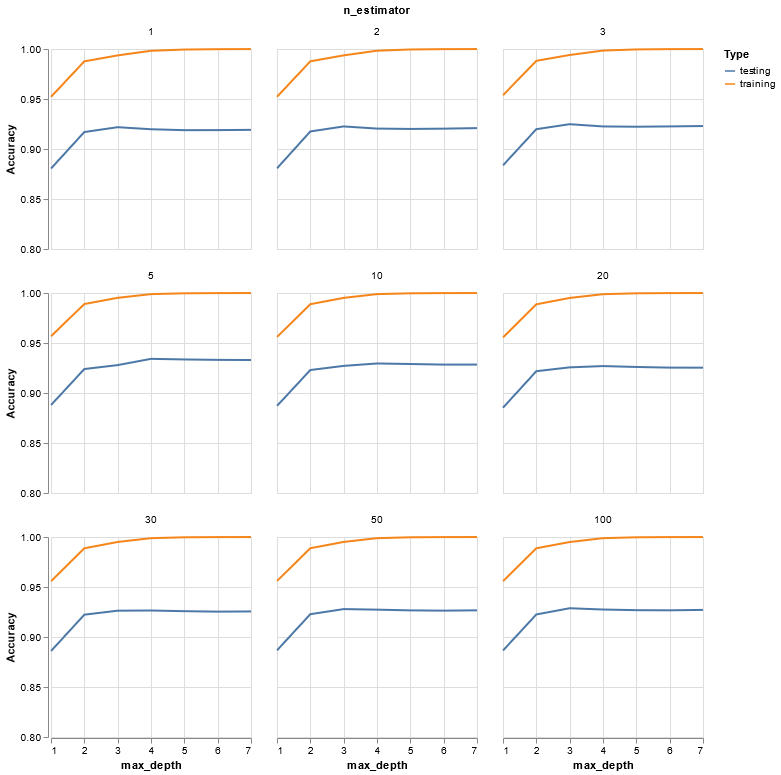

In [14]:
n_est = [1,2,3,5,10,20,30,50,100]
max_depth = range(1,8)
X_train, X_test, y_train, y_test = test_train_compound(df, "tbp")
trees = []
train_acc = []
test_acc = []
depth = []
for j in max_depth:
    for i in n_est:
        trees.append(i)
        depth.append(j)
        rf = RandomForestRegressor(n_estimators = i, max_depth = j, random_state=0).fit(X_train, y_train)
        train_acc.append(rf.score(X_train, y_train))
        test_acc.append(rf.score(X_test, y_test))
        #print(j,i)
df_rf = pd.DataFrame({'training' : train_acc,
                      'testing' : test_acc,
                      'n_estimator' : trees,
                      'max_depth' : depth})
df_rf = df_rf.melt(id_vars = ['n_estimator', 'max_depth'], var_name = 'Type', value_name = 'Accuracy')
df_rf
alt.Chart(df_rf).mark_line().encode(
    alt.X('max_depth'),
    alt.Y('Accuracy', scale=alt.Scale(domain=[0.8, 1])),
    alt.Color('Type'),
    alt.Facet('n_estimator')
    ).properties(width = 200, height = 200, columns = 3)

## SVR

kernel="rbf", C=100, gamma=0.1, epsilon=0.1

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

In [15]:
def svr_rbf(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    svr_rbf = SVR(kernel="rbf").fit(X_train, y_train)
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = svr_rbf.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_svr_rbf_{}.csv'.format(product))
    
    print("The training accuracy for the model is ", svr_rbf.score(X_train, y_train))
    print("The testing accuracy for the model is ", svr_rbf.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'SVR RBF Kernel',
                           'Train Accuracy': svr_rbf.score(X_train, y_train),
                           'Test Accuracy' : svr_rbf.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(svr_rbf(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.9147256033751606
The testing accuracy for the model is  0.7586294199138922
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.9142779136957417
The testing accuracy for the model is  0.9022576585840489


## GBR

In [16]:
def gbr(df, product):
    X_train, X_test, y_train, y_test = test_train_compound(df, product)
    print("The 4 matrices for --", product, "-- are of sizes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    gbr = GradientBoostingRegressor().fit(X_train,y_train)
    
    df_pred = df.query("compound == @product").copy()
    df_pred['predicted_wt'] = gbr.predict(df.query("compound == @product")[['Ts', 'HF', 'Tr']])
    df_pred.to_csv(r'../output/scenario2/prediction_gbr_{}.csv'.format(product))
    
    print("The training accuracy for the model is ", gbr.score(X_train, y_train))
    print("The testing accuracy for the model is ", gbr.score(X_test, y_test))
    
    return pd.DataFrame({'Model': 'Gradient Boost Regressor',
                           'Train Accuracy': gbr.score(X_train, y_train),
                           'Test Accuracy' : gbr.score(X_test, y_test),
                           'Compound' : i}, index=[None])

for i in df.compound.value_counts().index:
    df_results = df_results.append(gbr(df, i))

The 4 matrices for -- tbp_fe2o3 -- are of sizes:  (55719, 3) (21705, 3) (55719,) (21705,)
The training accuracy for the model is  0.9907682091231479
The testing accuracy for the model is  0.7385531990018128
The 4 matrices for -- tbp -- are of sizes:  (41468, 3) (16008, 3) (41468,) (16008,)
The training accuracy for the model is  0.99979946896864
The testing accuracy for the model is  0.9632312860049882


In [17]:
df_results

,Model,Compound,Train Accuracy,Test Accuracy
NaN,Linear Regression,tbp_fe2o3,0.569406,0.375724
NaN,Linear Regression,tbp,0.561347,0.620327
NaN,Partial Least Squares (n=2),tbp_fe2o3,0.569265,0.319843
NaN,Partial Least Squares (n=2),tbp,0.561341,0.619545
NaN,Partial Least Squares (n=3),tbp_fe2o3,0.569406,0.375724
NaN,Partial Least Squares (n=3),tbp,0.561347,0.620327
NaN,Random Forest Regression (max_depth = 2),tbp_fe2o3,0.962736,0.758253
NaN,Random Forest Regression (max_depth = 2),tbp,0.988724,0.922545
NaN,Random Forest Regression (max_depth = 5),tbp_fe2o3,0.987230,0.690667
NaN,Random Forest Regression (max_depth = 5),tbp,0.999712,0.926832


1 1
1 2
1 3
1 5
1 10
1 20
1 30
1 50
1 100
2 1
2 2
2 3
2 5
2 10
2 20
2 30
2 50
2 100
3 1
3 2
3 3
3 5
3 10
3 20
3 30
3 50
3 100
4 1
4 2
4 3
4 5
4 10
4 20
4 30
4 50
4 100
5 1
5 2
5 3
5 5
5 10
5 20
5 30
5 50
5 100
6 1
6 2
6 3
6 5
6 10
6 20
6 30
6 50
6 100
7 1
7 2
7 3
7 5
7 10
7 20
7 30
7 50
7 100


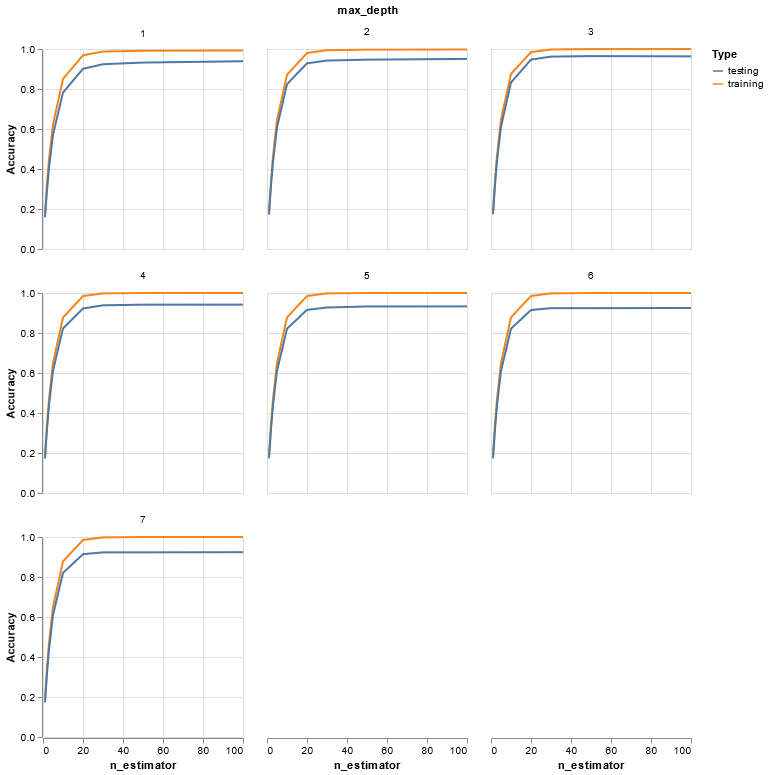

In [19]:
n_est = [1,2,3,5,10,20,30,50,100]
max_depth = range(1,8)
X_train, X_test, y_train, y_test = test_train_compound(df, "tbp")
trees = []
train_acc = []
test_acc = []
depth = []
for j in max_depth:
    for i in n_est:
        trees.append(i)
        depth.append(j)
        gbr = GradientBoostingRegressor(n_estimators = i, max_depth = j, random_state=0).fit(X_train, y_train)
        train_acc.append(gbr.score(X_train, y_train))
        test_acc.append(gbr.score(X_test, y_test))
        print(j,i)
df_gbr = pd.DataFrame({'training' : train_acc,
                      'testing' : test_acc,
                      'n_estimator' : trees,
                      'max_depth' : depth})
df_gbr = df_gbr.melt(id_vars = ['n_estimator', 'max_depth'], var_name = 'Type', value_name = 'Accuracy')
df_gbr
alt.Chart(df_gbr).mark_line().encode(
    alt.X('n_estimator'),
    alt.Y('Accuracy', scale=alt.Scale(domain=[0, 1])),
    alt.Color('Type'),
    alt.Facet('max_depth')
    ).properties(width = 200, height = 200, columns = 3)

## Write results to file

In [20]:
df_results.to_csv('../output/scenario2/results_table.csv')